Exploratory Data Analysis 

In [16]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot, df_to_pdf, plot_to_pdf
from utilities_widgets import position_chart
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [17]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [18]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('INAMARSA_Fixtu…

Table *INAMARSA_Measurements_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_Limits_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_FixtureData_2024y_05m_07d_12h_48m_47s* retrieved succesfully.


In [19]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    INAMARSA_Measurements_2024y_03m_21d_11h_48m_04s
    INAMARSA_Limits_2024y_03m_21d_11h_48m_04s
    INAMARSA_FixtureData_2024y_05m_07d_12h_48m_47s


In [20]:
#Fixture metadata preparation
if "FIXTURE_DATA" not in globals(): #Gets data directly from the globals file
    FIXTURE_DATA = pd.DataFrame.from_records([glob.__dict__]).transpose()
    FIXTURE_DATA.rename(columns={0:"Tooling data"}, inplace=True)
    FIXTURE_DATA.rename(index={"tooling": "Tooling name", "lenses_per_nest": "Lenses per nest", "nests_number": "Number of nests", "x_tolerance":"X-axis tolerance",
                            "y_tolerance":"Y-axis tolerance", "lo_tolerance":"Lower tolerance", "hi_tolerance": "Higher tolerance"}, inplace=True)
print("Fixture metadata:")
display(FIXTURE_DATA)

Fixture metadata:


,Tooling data
Tooling name,INAMARSA
Lenses per nest,3
Number of nests,4
X-axis tolerance,0.0125
Y-axis tolerance,0.0165
Lower tolerance,0.02
Higher tolerance,0.03


In [21]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 16,test: 17,test: 18,test: 19,test: 20,test: 21,test: 22,test: 23,test: 24,test: 25
Guia_Luz_Blanco_FB1_X,0.3580,0.3580,0.3579,0.3580,0.3579,0.3580,0.3579,0.3579,0.3579,0.3579,...,0.3579,0.3580,0.3580,0.3579,0.3580,0.3581,0.3581,0.3580,0.3580,0.3581
Guia_Luz_Blanco_FB1_Y,0.3256,0.3256,0.3253,0.3254,0.3253,0.3254,0.3253,0.3253,0.3255,0.3254,...,0.3254,0.3252,0.3251,0.3252,0.3251,0.3252,0.3251,0.3253,0.3252,0.3252
Guia_Luz_Blanco_FB2_X,0.3568,0.3568,0.3566,0.3566,0.3566,0.3566,0.3566,0.3566,0.3567,0.3566,...,0.3567,0.3565,0.3565,0.3565,0.3564,0.3565,0.3565,0.3566,0.3566,0.3566
Guia_Luz_Blanco_FB2_Y,0.3278,0.3276,0.3275,0.3275,0.3277,0.3278,0.3278,0.3278,0.3278,0.3276,...,0.3277,0.3276,0.3277,0.3277,0.3278,0.3278,0.3275,0.3276,0.3276,0.3275
Guia_Luz_Blanco_FB3_X,0.3479,0.3478,0.3476,0.3477,0.3478,0.3479,0.3479,0.3479,0.3479,0.3478,...,0.3479,0.3478,0.3478,0.3479,0.3479,0.3479,0.3478,0.3478,0.3478,0.3478
Guia_Luz_Blanco_FB3_Y,0.3302,0.3302,0.3302,0.3303,0.3301,0.3301,0.3301,0.3302,0.3302,0.3302,...,0.3302,0.3303,0.3296,0.3302,0.3302,0.3302,0.3302,0.3302,0.3303,0.3303
Guia_Luz_Blanco_FB4_X,0.3546,0.3546,0.3546,0.3547,0.3546,0.3546,0.3546,0.3546,0.3546,0.3546,...,0.3546,0.3547,0.3541,0.3547,0.3546,0.3547,0.3547,0.3546,0.3547,0.3547
Guia_Luz_Blanco_FB4_Y,0.3370,0.3370,0.3369,0.3369,0.3371,0.3369,0.3370,0.3370,0.3371,0.3370,...,0.3370,0.3369,0.3370,0.3370,0.3372,0.3370,0.3369,0.3369,0.3369,0.3369
Guia_Luz_Blanco_FB5_X,0.3562,0.3561,0.3561,0.3561,0.3562,0.3561,0.3561,0.3561,0.3563,0.3562,...,0.3561,0.3561,0.3562,0.3561,0.3563,0.3561,0.3561,0.3561,0.3561,0.3561
Guia_Luz_Blanco_FB5_Y,0.3275,0.3277,0.3275,0.3277,0.3276,0.3274,0.3277,0.3276,0.3276,0.3276,...,0.3275,0.3275,0.3276,0.3276,0.3277,0.3276,0.3276,0.3276,0.3276,0.3277


In [22]:
##Limits preparation
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("Limits:")
display(LIMITS_format)

Limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.325,0.358
Guia_Luz_Blanco_FB1_Y,0.310,0.335
Guia_Luz_Blanco_FB2_X,0.325,0.358
Guia_Luz_Blanco_FB2_Y,0.310,0.335
Guia_Luz_Blanco_FB3_X,0.325,0.358
Guia_Luz_Blanco_FB3_Y,0.310,0.335
Guia_Luz_Blanco_FB4_X,0.325,0.358
Guia_Luz_Blanco_FB4_Y,0.310,0.335
Guia_Luz_Blanco_FB5_X,0.325,0.358
Guia_Luz_Blanco_FB5_Y,0.310,0.335


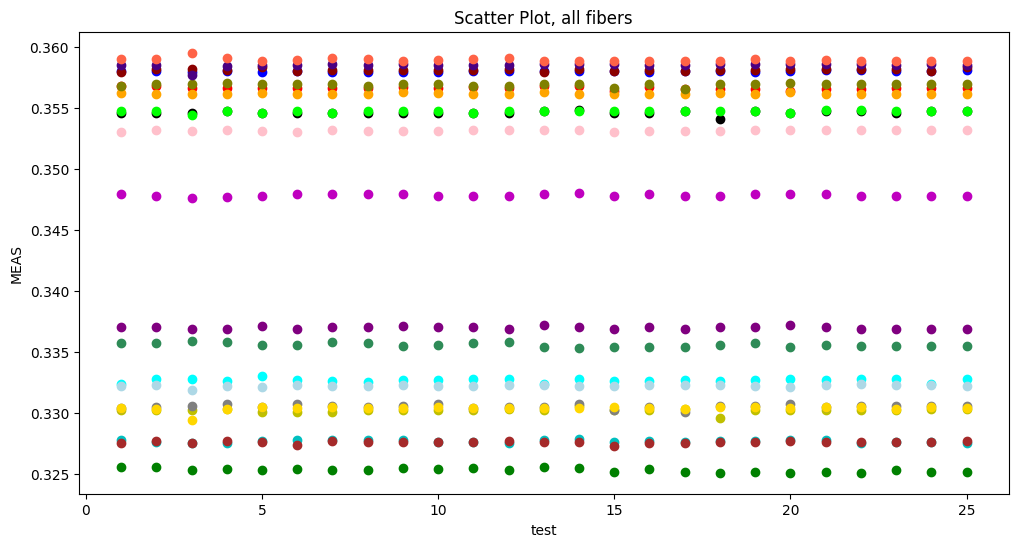

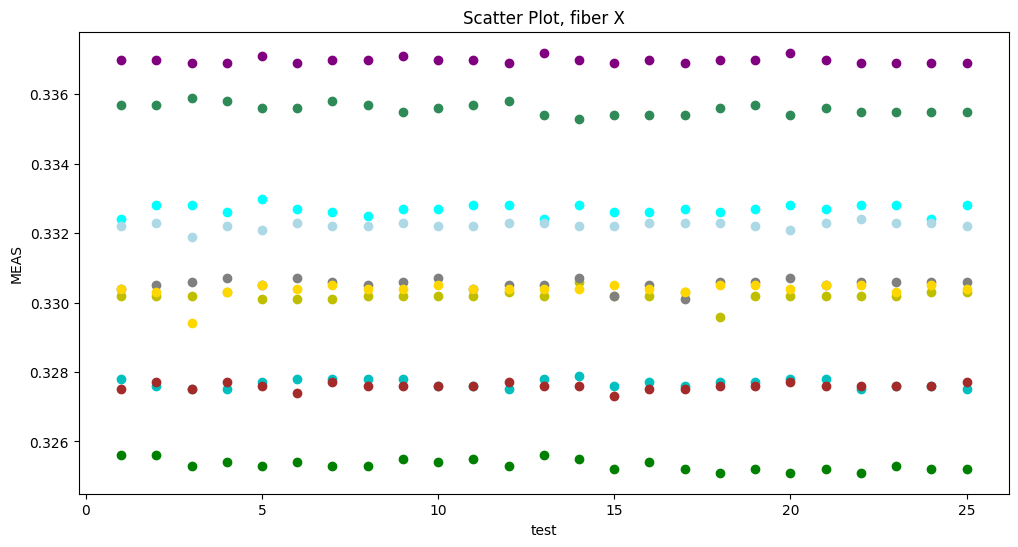

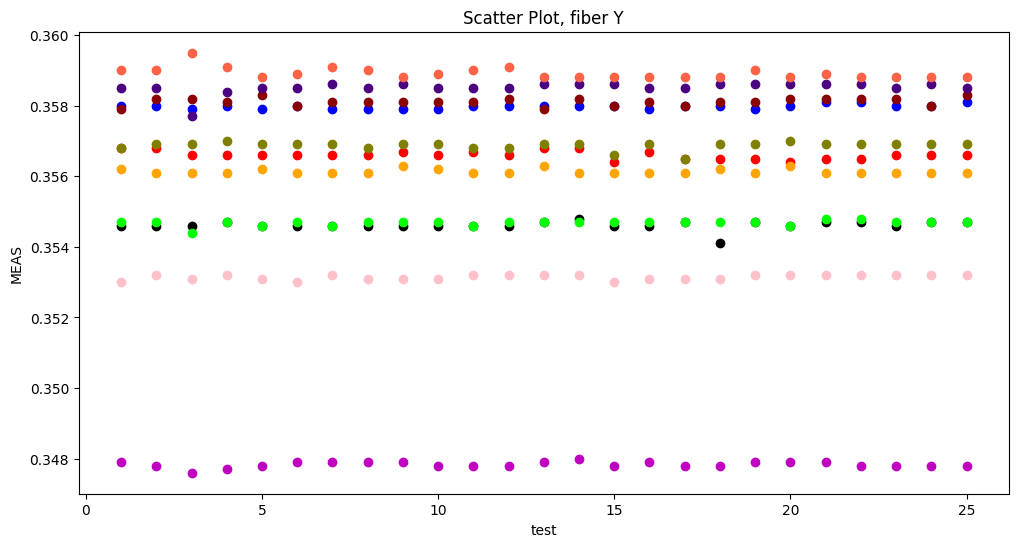

In [23]:
##Visualizations
fig = plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
fig = plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
fig = plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [24]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,25.0,0.357980,0.000065,0.3579,0.3579,0.3580,0.3580,0.3581
Guia_Luz_Blanco_FB1_Y,25.0,0.325328,0.000157,0.3251,0.3252,0.3253,0.3254,0.3256
Guia_Luz_Blanco_FB2_X,25.0,0.356608,0.000115,0.3564,0.3565,0.3566,0.3567,0.3568
Guia_Luz_Blanco_FB2_Y,25.0,0.327672,0.000124,0.3275,0.3276,0.3277,0.3278,0.3279
Guia_Luz_Blanco_FB3_X,25.0,0.347836,0.000081,0.3476,0.3478,0.3478,0.3479,0.3480
Guia_Luz_Blanco_FB3_Y,25.0,0.330200,0.000158,0.3296,0.3302,0.3302,0.3302,0.3306
Guia_Luz_Blanco_FB4_X,25.0,0.354620,0.000122,0.3541,0.3546,0.3546,0.3547,0.3548
Guia_Luz_Blanco_FB4_Y,25.0,0.336984,0.000090,0.3369,0.3369,0.3370,0.3370,0.3372
Guia_Luz_Blanco_FB5_X,25.0,0.356140,0.000071,0.3561,0.3561,0.3561,0.3562,0.3563
Guia_Luz_Blanco_FB5_Y,25.0,0.327588,0.000097,0.3273,0.3276,0.3276,0.3276,0.3277


Analysis of faulty fibers

In [25]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Adds an absolute fiber number for quick identification
LARGEST = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filters the 5 largest values
display(LARGEST)

,std,Fiber number
Guia_Luz_Blanco_FB9_Y,0.000216,18
Guia_Luz_Blanco_FB10_X,0.000178,19
Guia_Luz_Blanco_FB11_X,0.000165,21
Guia_Luz_Blanco_FB3_Y,0.000158,6
Guia_Luz_Blanco_FB10_Y,0.000157,20


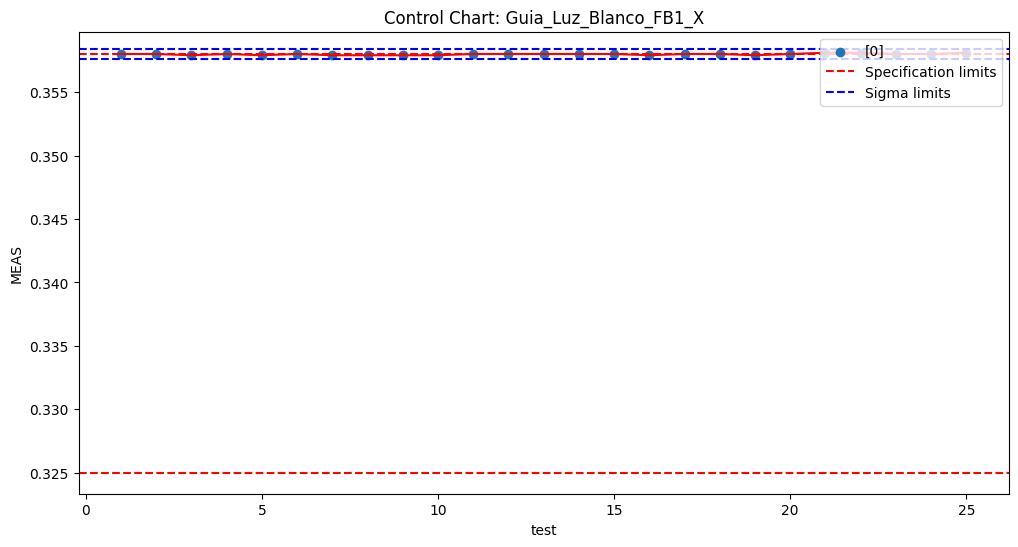

In [26]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title=f'Control Chart: {fiber_selection.value}', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

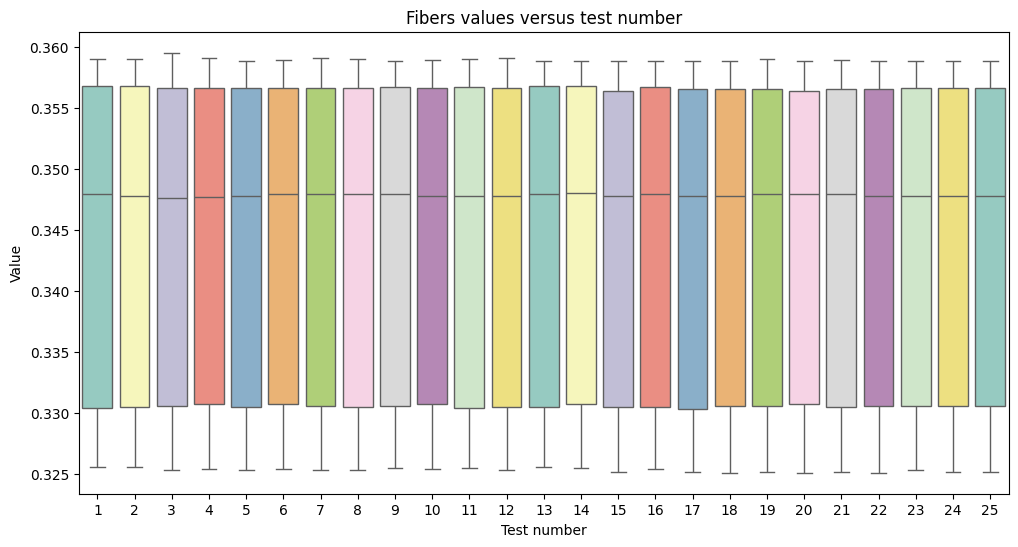

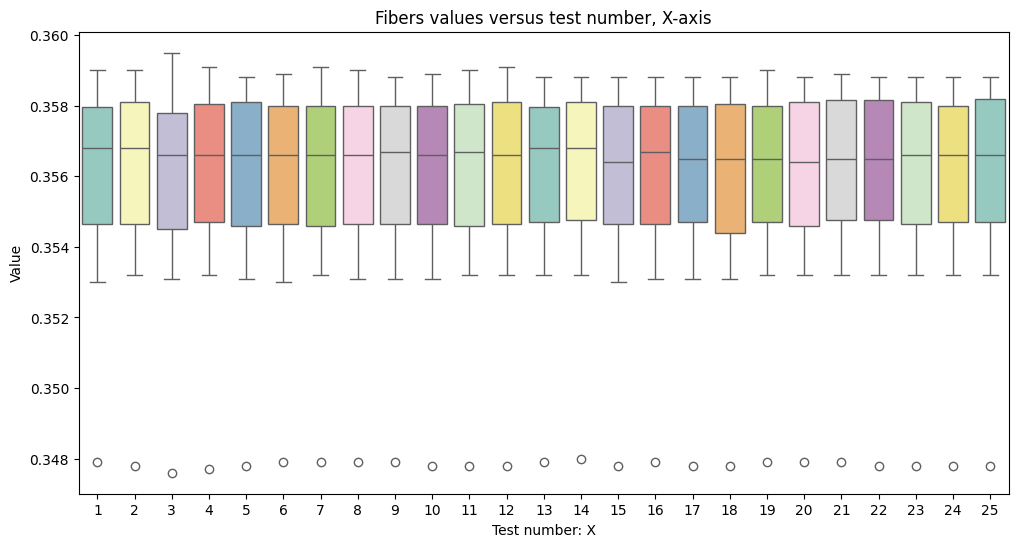

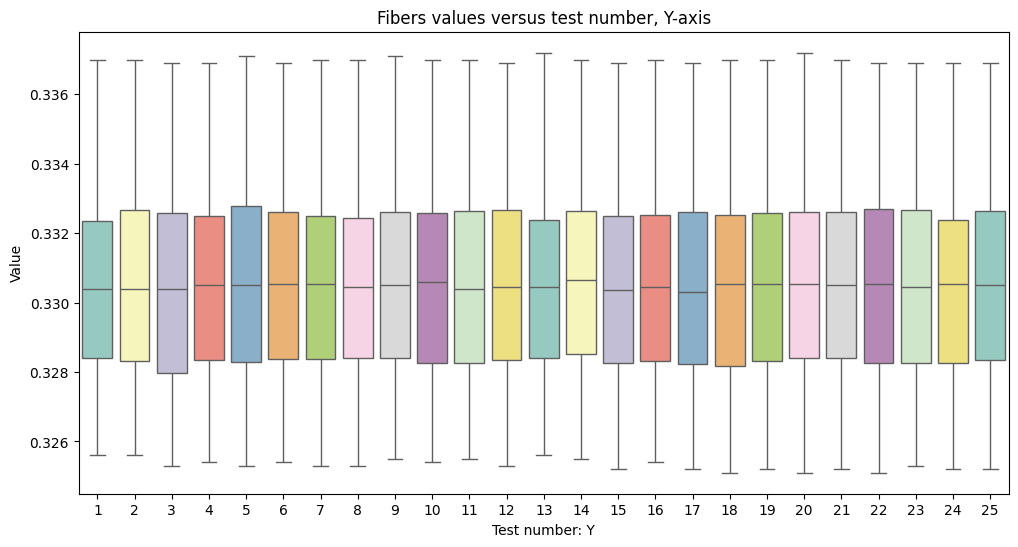

In [27]:
##Boxplot visualization
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number", xlabel="Test number", ylabel="Value", filter=None)
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, Y-axis", xlabel="Test number: ", ylabel="Value", filter="Y")
#fig = plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

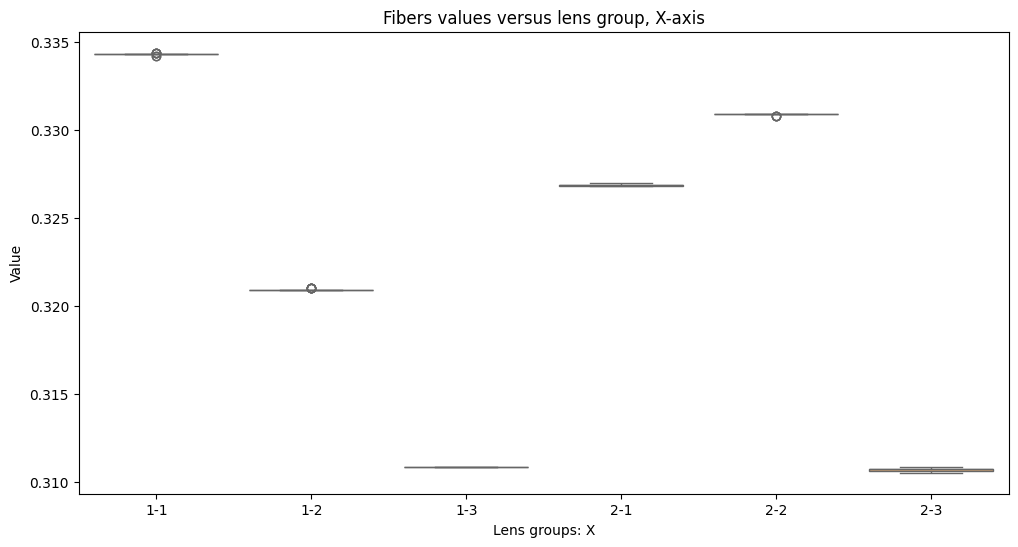

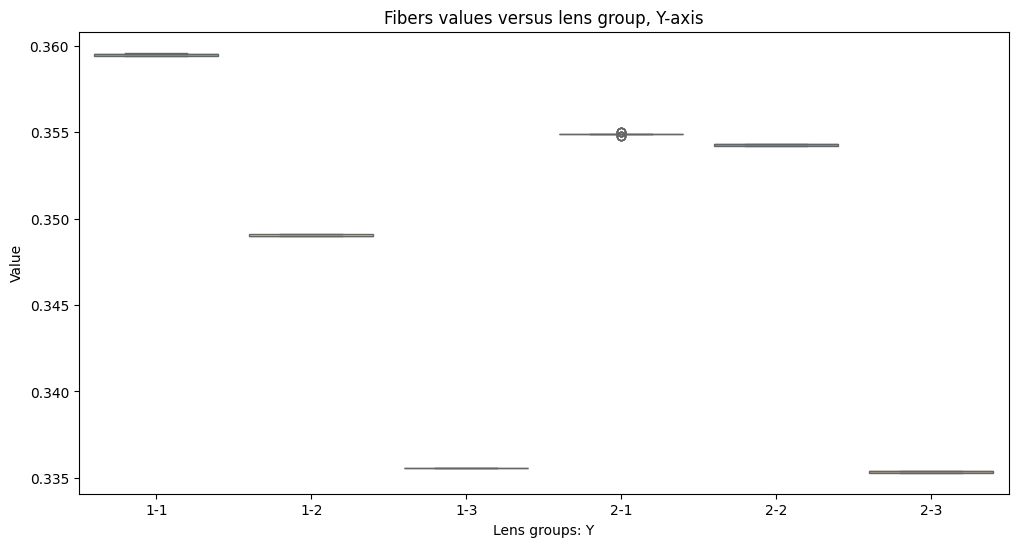

In [13]:
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, X-axis", xlabel="Lens groups: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, Y-axis", xlabel="Lens groups: ", ylabel="Value", filter="Y", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

In [28]:
output_html([FIXTURE_DATA, MEAS_format, LIMITS_format, RESUME_format, LARGEST], "EDA.html")

In [30]:
######Terminar
##Data export
date = get_date()
name_xlsx = glob.tooling + "_EDA_" + get_date() + ".xlsx"
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.abspath("../a2_output/reports")
    DATA = pd.concat([MEAS_format, LIMITS_format], axis=1)
    plot_to_pdf(MEAS, name=name_scatter, plot="SCATTER")
    plot_to_pdf([MEAS_format, FIXTURE_DATA], name=name_bloxplot, plot="BOXPLOT")
    #output_html([MEAS_format, LIMITS_format], "EDA.html")
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\User\Desktop\Luciano\Python_Eiit_RyR\a2_Analyser\a2_output
